# A3: Visualization for Exploratory Data Analysis (part 2)

## Real Estate EDA

**Real estate data**

Imagine you are a data scientist working at a real-estate company. In this week, your job is to analyze Vancouver housing prices. First, inspect the dataset provided via OneDrive link: [property_tax_report_2023.zip](https://1sfu-my.sharepoint.com/:u:/g/personal/sbergner_sfu_ca/EeHhDuSuAO5Hh6noBM_czBgBtunRYLjY-JXxL2l9yeQWSg?e=iCWZWU). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2023.
You can find the schema information of the dataset from the [Vancouver Open Data Portal](https://opendata.vancouver.ca/explore/dataset/property-tax-report/information/).
Familiarize yourself with the context and background info on that page before diving deeper into Exploratory Data Analysis.

### Loading data
Below we load the dataset into DataFrame by reusing the code from Part 1


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
def displaymd(mdstr):
    display(Markdown(mdstr))

In [2]:

# use this in case you have a hidpi display and figures appear blurry
#%config InlineBackend.figure_format = 'retina'

# before running this, unzip the provided data
df = pd.read_csv("property-tax-report_2023.csv", sep=';')

df['CURRENT_PRICE'] = df.apply(lambda x: x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df['PREVIOUS_PRICE'] = df.apply(lambda x: x['PREVIOUS_LAND_VALUE']+x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)


### Step 8. Obtain geographic coordinates for Canadian postal codes

The property data carries Canadian postal codes, but latitude/longitude coordinates would be much more useful. Unfortunately, geolocations of Canadian postal codes are protected by copyright and the information has to be purchased. Fortunately, you already paid for it with your tuition...

Statistics Canada has a protected dataset, the postal code conversion file, which is available to SFU students via the Abacus Dataverse. Please follow these steps:
* Have a valid SFU account (not sure if alumni account would work)
* Connect to the Abacus Data Network via https://databases.lib.sfu.ca/record/61245148090003610/Abacus-Data-Network
* Connecting via the above link should show you as logged in user at https://abacus-library-ubc-ca.proxy.lib.sfu.ca/
* Search for: **Postal Code Conversion File May 2021**
* Download files: **pccfNat_fccpNat_052021.txt** and the [2021 PCCF Guide .pdf](https://abacus.library.ubc.ca/file.xhtml?persistentId=hdl:11272.1/AB2/9J8YUH/WJHERN&version=1.0) and place them in the same folder as this notebook.

#### Details about the dataset in the 2021 PCCF Guide
* Description of available fields for each postal code, see Content section, pp. 9
* Offsets and Size of fields to extract from lines in Postal Code Conversion File, Table 4.1, p. 11.  
  This is also included along with this notebook as **pccf_record_layout.csv**

In [3]:
rldf = pd.read_csv('pccf_record_layout.csv')
# load the raw text pccf file
with open('pccfNat_fccpNat_052021.txt','r', encoding='latin-1') as fh:
    pctxt = fh.read()
pclines = pctxt.split('\n')
pclines = list(filter(lambda l: len(l), pclines)) # keep only non-empty lines
displaymd(f"Number of lines in PCCF: {len(pclines):,}")

Number of lines in PCCF: 1,742,403

The following extraction of substrings works, but is *very slow*. Please use [pandas string methods](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) to make this faster.  
**TODO** write your improved code here.

In [4]:
# 1) Build column positions from the layout file (rldf)
#    The layout uses 1-based positions, but Python uses 0-based indexing,
#    so we subtract 1 from the start position.
starts = rldf['Position'].astype(int) - 1

# The end position is start + field length (Size)
ends = starts + rldf['Size'].astype(int)

# Combine start and end positions into a list of (start, end) pairs
# This tells pandas where each column is located in the text line.
colspecs = list(zip(starts, ends))

# Get the column names from the layout file
names = rldf['Field name'].tolist()


# 2) Read the fixed-width text file using pandas
# Pandas will cut each line based on colspecs
# and assign column names using the list above.
pccf_df = pd.read_fwf(
    'pccfNat_fccpNat_052021.txt',  # PCCF fixed-width text file
    colspecs=colspecs,            # column start and end positions
    names=names,                  # column names
    dtype=str,                    # read everything as string for safety
    encoding='latin-1'            # file encoding
)

In [5]:
pccf_df['LAT'] = pccf_df['LAT'].astype(float)
pccf_df['LONG'] = pccf_df['LONG'].astype(float)
pccf_short = pccf_df[['Postal code', 'LONG', 'LAT', 'CSDname']]
pccf_short = pccf_short.groupby('Postal code').agg({'LONG':'mean','LAT':'mean','CSDname':'first'})

Now we're ready to merge geolocation to our property data.

In [6]:
df['Postal code'] = df['PROPERTY_POSTAL_CODE'].str.replace(' ','')
dfgeo = df.merge(pccf_short, on='Postal code')

**TODO Outlier check**: Please take a look at the property locations by using a suitable visualization.
You can use the longitude and latitude information to plot the properties. Pick a suitable visualization to decide the right cutoff.
The goal is to check for outliers and remove them if necessary. 

Depending on the postal code PCCF year you are using, there can be outliers.
In case there are locations outside Vancouver, e.g. near Squamish, BC, outside Vancouver proper, please remove them.

If you decide to remove some postal codes, please write a comment explaining your decision.
Also, if after viewing the plot, you decide that all postal code locations are within Vancouver,
please write a comment to that effect.

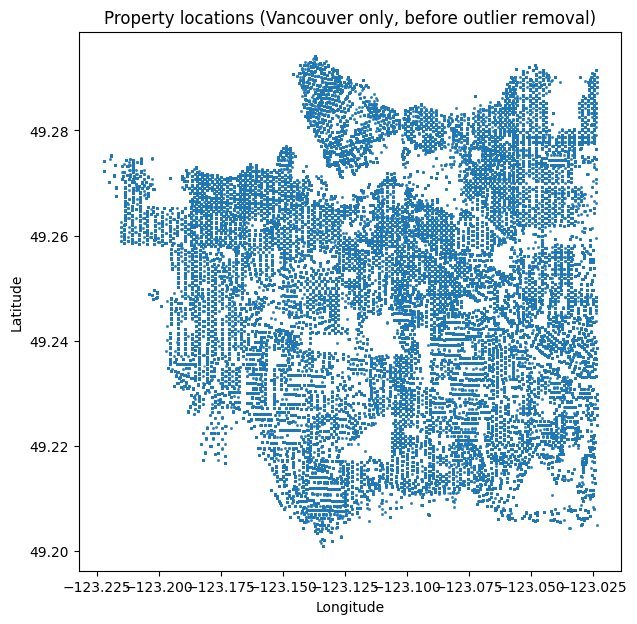

Rows before filtering: 1,070,244
Rows after filtering : 1,070,244
Removed as outliers  : 0


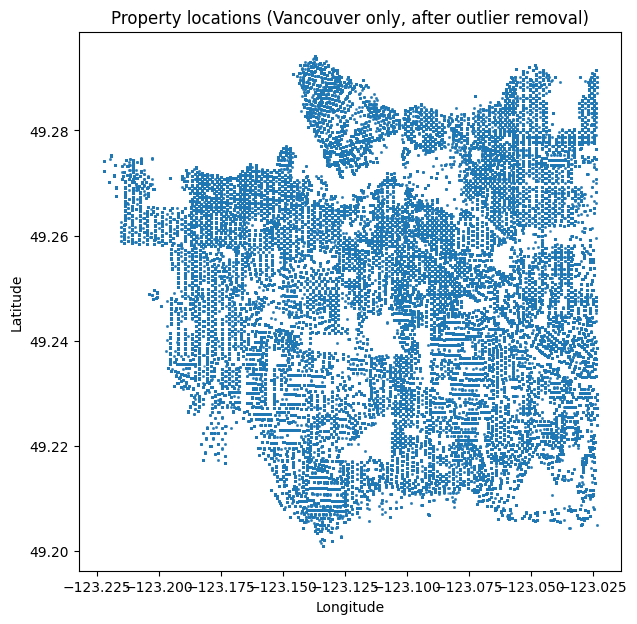

In [7]:
# 0) First, keep only properties whose city is Vancouver
dfgeo_city = dfgeo[dfgeo['CSDname'] == 'Vancouver'].copy()

# Remove rows with missing coordinates
dfgeo_clean = dfgeo_city.dropna(subset=['LAT', 'LONG']).copy()

# 1) Scatter plot of Vancouver property locations (before outlier removal)
plt.figure(figsize=(7, 7))
plt.scatter(dfgeo_clean['LONG'], dfgeo_clean['LAT'], s=1, alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Property locations (Vancouver only, before outlier removal)")
plt.show()

# 2) Define a rough bounding box for Vancouver
lat_min, lat_max = 49.20, 49.33
lon_min, lon_max = -123.30, -123.00

# Create a mask: True if the point is inside Vancouver, False otherwise
mask_van = (
    (dfgeo_clean['LAT'] >= lat_min) & (dfgeo_clean['LAT'] <= lat_max) &
    (dfgeo_clean['LONG'] >= lon_min) & (dfgeo_clean['LONG'] <= lon_max)
)

# Keep only the rows inside the Vancouver area
dfgeo_van = dfgeo_clean[mask_van].copy()

# Count how many rows were removed
n_removed = len(dfgeo_clean) - len(dfgeo_van)

print(f"Rows before filtering: {len(dfgeo_clean):,}")
print(f"Rows after filtering : {len(dfgeo_van):,}")
print(f"Removed as outliers  : {n_removed:,}")

# 3) Scatter plot after removing outliers
plt.figure(figsize=(7, 7))
plt.scatter(dfgeo_van['LONG'], dfgeo_van['LAT'], s=1, alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Property locations (Vancouver only, after outlier removal)")
plt.show()

# Assignment comment:
# First, we restricted the dataset to properties whose CSDname is Vancouver.
# After visual inspection using latitude and longitude, all points fall within
# the Vancouver area. No geographic outliers were detected.

Feel free to use the function below to prepare a heatmap of averages. The code is based on [Matthew McGonagle's blog post](https://matthewmcgonagle.github.io/blog/2019/01/22/HeatmapBins).

In [8]:
def heatmap_bins(data, fieldsxy, ncuts=30, aggarg='mean'):
    """Perform data.groupby using bin cuts along columns named in fieldsxy.
    Args:
        data     - pandas dataframe
        fieldsxy - list of column names along which to perform binned groupby
        ncuts    - number of cuts to perform for each field (see pd.cut)
        aggarg   - aggregation operation to perform, default: 'mean'
    Returns:
        grouped dataframe, ready for plotting via sns.heatmap(means['COLUMNAME'])
    """
    # based on: https://matthewmcgonagle.github.io/blog/2019/01/22/HeatmapBins
    cuts = pd.DataFrame({str(feature) + ' bins' : pd.cut(data[feature], ncuts) for feature in fieldsxy})
    means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)
    means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
    # Reverse the order of the rows as the heatmap will print from top to bottom.
    means = means.iloc[::-1]
    return means

**TODO** plot a heatmap of average current property prices, within the same geographic area

Note that the colormap may be useless due to a few extreme values. Rather than removing them as 'outliers', please just map the values before drawing with a suitable choice of logarithm.

/var/folders/hf/ndbx766s1wz64f0tzx4x6fb40000gn/T/ipykernel_28701/407323472.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)


([], [])

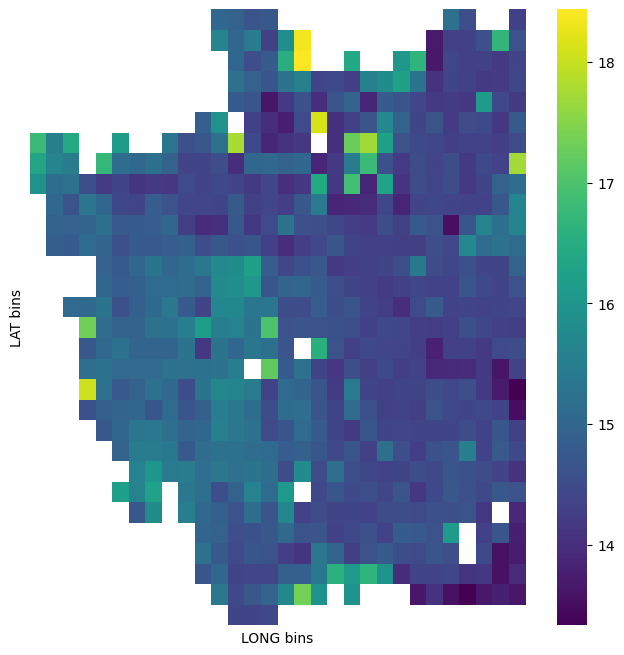

In [9]:
# Choose the column to visualize (current property price)
field = 'CURRENT_PRICE'

# Set the figure size only inside this block
with plt.rc_context({'figure.figsize': (8,8)}):

    # Create a binned 2D table (LONG x LAT) with mean values
    means = heatmap_bins(dfgeo_van, ['LONG', 'LAT'], ncuts=30, aggarg='mean')

    # Draw a heatmap using the log of the average prices
    # log(1 + x) is used to reduce the effect of very large values
    sns.heatmap(
        np.log1p(means[field]),
        cmap='viridis'
    )

# Hide x and y axis ticks to make the plot look like a map
plt.xticks([], [])
plt.yticks([], [])

Please write down the **two** most interesting findings that you draw from the plot. 

**Findings**
1. Properties in the western area show higher average prices compared to the eastern side.
2. There is a clear price gradient across the city, indicating strong spatial variation in property values.


### Task 9: Integrate with BC Assessment data

BC Assessment is a governmental institution that provides valuation estimates for real-estate properties, so-called folios, around British Columbia.

SFU Library recently obtained access to the BCA Advice data, subject to conditions laid out in their End-user license agreement (EULA), for instance:
* free for research and classroom use only
* publication of results only with BCA consent (i.e. no public github repo with data or results)
* follow further criteria listed in the EULA.

In order to use the dataset we prepared, you have to agree to the EULA provided by BCA.

**Please follow the steps in the [BCA EULA sigsheet](https://1sfu-my.sharepoint.com/:x:/g/personal/zhengjie_sfu_ca/IQA-YNsViA3EQJHBrBO1CLGxAcOf_UgfMODU78Ry_fj4hNI?e=Jvc97F&nav=MTVfezAwMDAwMDAwLTAwMDEtMDAwMC0wMDAwLTAwMDAwMDAwMDAwMH0) to obtain the dataset.**

In [10]:
# Load the dataset

bcadf = pd.read_csv('bca-data/sales-residential-2022-cleaned.csv')

/var/folders/hf/ndbx766s1wz64f0tzx4x6fb40000gn/T/ipykernel_28701/633965471.py:3: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  bcadf = pd.read_csv('bca-data/sales-residential-2022-cleaned.csv')


#### 9.a Add latitude and longitude info

**TODO:** Obtain geographic coordinates for Canadian postal codes and merge them with existing dataframe

Use the `pccf_df` that you made before and join it with the bca data. Ensure that you get latitude and longitude, as well as, CSDname of the city or community for each folioID.


In [11]:
# Make a clean postal code in the BCA data (remove spaces)
bcadf['Postal code'] = bcadf['postalCode'].astype(str).str.replace(' ', '')

# Merge: add LAT/LONG/CSDname to the BCA data
dfgeo = bcadf.merge(pccf_short, on='Postal code', how='left')

# Quick check
dfgeo[['folioID', 'Postal code', 'LAT', 'LONG', 'CSDname']].head()

,folioID,Postal code,LAT,LONG,CSDname
0,A0000PYTHX,V0C2C0,55.715470,-120.133613,Pouce Coupe
1,A0000F88KH,V2V4J1,49.215917,-122.233126,Fraser Valley G
2,D0000TSC16,V0J2B0,53.924577,-121.577344,Fraser-Fort George F
3,D0000CZXSJ,V8W0B8,48.429526,-123.363209,Victoria
4,A0000HQC0A,V9B4P5,48.445974,-123.500606,Langford


#### 9.b Create a quantitative map of Vancouver properties

Use the CSDName and limit the dataset to foloID's for `Vancouver` only. Then  perform the following:

Create a plot of `conveyancePrice` on a map. You can either draw individual color coded points or construct a heatmap using code from before.

/var/folders/hf/ndbx766s1wz64f0tzx4x6fb40000gn/T/ipykernel_28701/407323472.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)


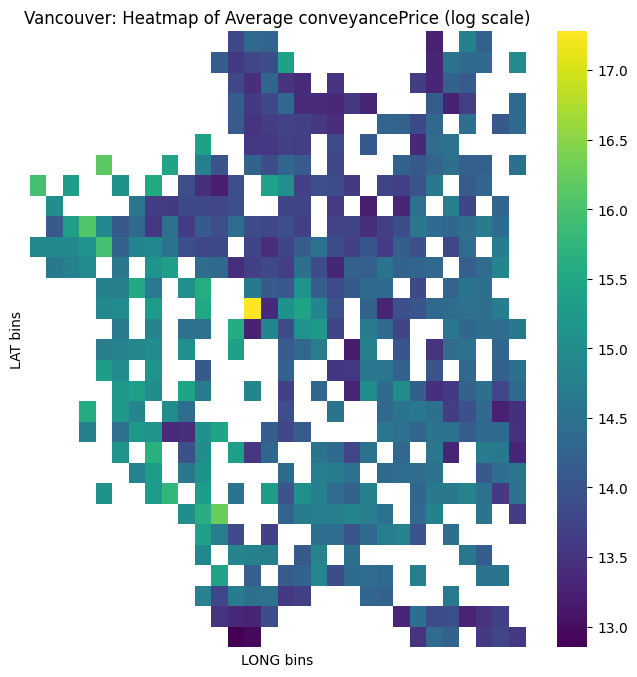

In [18]:
# Keep only Vancouver properties
dfgeo_van = dfgeo[dfgeo['CSDname'] == 'Vancouver'].copy()

# Choose the value to show on the map
field = 'conveyancePrice'

# Create a heatmap of average prices by location
with plt.rc_context({'figure.figsize': (8, 8)}):

    # Make 2D binned averages using LONG and LAT
    means = heatmap_bins(dfgeo_van, ['LONG', 'LAT'], ncuts=30, aggarg='mean')

    # Draw the heatmap using log scale to handle extreme values
    sns.heatmap(
        np.log1p(means[field]),
        cmap='viridis'
    )

# Hide axis ticks to make it look like a map
plt.xticks([], [])
plt.yticks([], [])
plt.title("Vancouver: Heatmap of Average conveyancePrice (log scale)")
plt.show()

#### 9.c Create one or multiple plots to explore possible relationships between other quantitative variables and conveyancePrice

For this question, please use the entire dataset.

1. Create a plot that shows how `conveyancePrice` relates to two (or more) other quantitative variables. We are hoping to use this plot to think about possible modeling choices for price predictions.

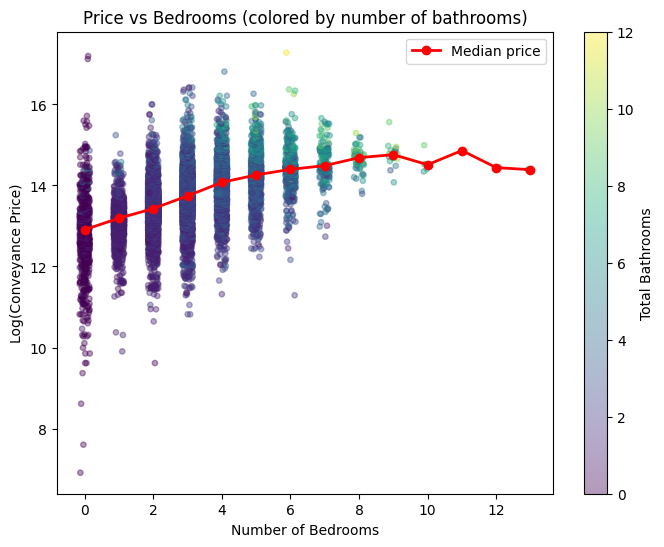

In [32]:
# Create a new column: total number of bathrooms
bcadf['total_baths'] = (
    bcadf['num_full_baths'].fillna(0) +
    bcadf['num_3-piece_baths'].fillna(0) +
    bcadf['num_2-piece_baths'].fillna(0)
)

# Replace NaN bedrooms with 0 (for studio or missing data)
bcadf['num_bedrooms_clean'] = bcadf['num_bedrooms'].fillna(0)

# Keep only needed columns
# Remove rows where price is missing
df_plot = bcadf[['conveyancePrice', 'num_bedrooms_clean', 'total_baths']] \
            .dropna(subset=['conveyancePrice'])

# Take log of price to reduce extreme differences
df_plot['log_price'] = np.log1p(df_plot['conveyancePrice'])

# Calculate median log price for each bedroom count
median_by_bed = (
    df_plot
    .groupby('num_bedrooms_clean')['log_price']
    .median()
)

# Add small random noise (jitter) to x-axis to avoid overlap
jitter = np.random.uniform(-0.15, 0.15, size=len(df_plot))
x_jitter = df_plot['num_bedrooms_clean'] + jitter

# Draw the scatter plot
plt.figure(figsize=(8,6))

sc = plt.scatter(
    x_jitter,                 # bedrooms with jitter
    df_plot['log_price'],     # log(price)
    c=df_plot['total_baths'], # color = number of bathrooms
    cmap='viridis',
    alpha=0.4,
    s=15
)

# Draw the median line
plt.plot(
    median_by_bed.index,
    median_by_bed.values,
    color='red',
    marker='o',
    linewidth=2,
    label='Median price'
)

# Labels and legend
plt.xlabel("Number of Bedrooms")
plt.ylabel("Log(Conveyance Price)")
plt.title("Price vs Bedrooms (colored by number of bathrooms)")
plt.legend()

# Color bar for bathrooms
cbar = plt.colorbar(sc)
cbar.set_label("Total Bathrooms")

plt.show()

Prices generally increase with more bedrooms and bathrooms.
The median price seems to decrease for 9+ bedrooms, but this is likely due to a very small sample size and atypical properties in that range.

## Submission

You need to complete the second part by filling out this notebook. Please submit <font color="blue">A3-2.ipynb</font> to Canvas.